# Propagation of Galactic Cosmic Rays

For small Larmor radii, solving the equations of motion to obtain the trajectories of individual particles become computationally prohibitive. As the propagation regime becomes less rectlinear and more diffusive, other methods have to be employed. 
Since CRPropa 3.1, this can be done for an ensemble of particles using stochastic differential equations (SDEs), which closely resemble transport equations.

This approach is particularly interesting for modelling the propagation of Galactic cosmic rays (GCRs).

### Assembling the simulation

We are going to study the propagation of GCRs in the Milky Way. 
The sources are assumed to follow the distribution of pulsars in the Galaxy (`SourcePulsarDistribution`). They are emitting CRs with a power law spectrum between 1 TeV and 10 PeV.

The magnetic field considered is the standard Jansson-Farrar model. 
The diffusion coefficient is given by
$$
\kappa_\parallel = \kappa_0 \left( \frac{E}{4 \; \text{GeV}} \right) \,,
$$
with $\kappa_0 = 6 \times 10^{28} \; \text{m}^2/\text{s}$ and $\alpha=1/3$.
The perpendicular component is related to the parallel one as follows:
$$
\kappa_\perp = \epsilon \kappa_\parallel \,.
$$
We assume $\epsilon=0.1$.


The observer in this case will be a time-evolving omnipresent observer, storing the state of the particles at successive time steps.

(This simulation can take several minutes.)

In [1]:
from crpropa import *

# general simulation parameters
nEvents = 50000
A, Z = 1, 1
energyRange = [100 * TeV, 100 * PeV]
epsilon = 0.1
minStep = 0.1 * parsec
maxStep = 10 * kpc
precision = 1e-2
outputFile = 'sim/galacticCRs.txt'
outputFileEscape = 'sim/galactic_escape.txt'
outputFileAge = 'sim/galactic_age.txt'

# magnetic field
magneticField = JF12Field()
magneticField.randomStriated()
magneticField.randomTurbulent()


# source distribution: uniform with power-law spectrum
position = SourcePulsarDistribution()
direction = SourceIsotropicEmission()
energySpectrum = SourcePowerLawSpectrum(*energyRange, -1)
particleType = SourceParticleType(nucleusId(A, Z))
source = Source()
source.add(position)
source.add(direction)
source.add(energySpectrum)
source.add(particleType)

# output
output = TextOutput(outputFile)
output.setEnergyScale(eV)
output.setLengthScale(kpc)
output.disableAll() # we wish to customize our observer
output.enable(Output.TrajectoryLengthColumn)
output.enable(Output.CurrentIdColumn)
output.enable(Output.CurrentPositionColumn)
output.enable(Output.CurrentDirectionColumn)
output.enable(Output.CurrentEnergyColumn)
output.enable(Output.SourceEnergyColumn)
output.enable(Output.SourceIdColumn)

outputEscape = TextOutput(outputFileEscape, Output.Event1D)
outputEscape.setEnergyScale(eV)
outputEscape.setLengthScale(kpc)
outputEscape.disable(Output.CandidateTagColumn)
outputAge = TextOutput(outputFileAge, Output.Event1D)
outputAge.setEnergyScale(eV)
outputAge.setLengthScale(kpc)
outputAge.disable(Output.CandidateTagColumn)

# observer: time-evolution of the cosmic-ray density
obsStepSize = 50 * kpc
obsNSteps = 100
observerTimeEvolution = ObserverTimeEvolution(obsStepSize, obsStepSize, obsNSteps)
observer = Observer()
observer.add(observerTimeEvolution)
observer.setDeactivateOnDetection(False)
observer.onDetection(output)

# propagator
propagator = DiffusionSDE(magneticField, precision, minStep, maxStep, epsilon)

# break conditions
breakTrajectory = MaximumTrajectoryLength(2000 * Mpc)
breakTrajectory.onReject(outputAge)
breakBoundary = CylindricalBoundary(Vector3d(0, 0, 0), 4 * kpc, 20 * kpc)
breakBoundary.onReject(outputEscape)

# assemble simulation components
sim = ModuleList()
sim.add(propagator)
sim.add(observer)
sim.add(breakTrajectory)
sim.add(breakBoundary)
sim.setShowProgress(True)
sim.run(source, nEvents, True)

output.close()
outputAge.close()
outputEscape.close()


crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Thu May 22 22:06:43 2025 : [ Finished ] 100%    Needed: 00:04:37  - Finished at Thu May 22 22:11:20 2025


### Helper functions

In [2]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Rmax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Rmax`: spectrum cuts off above Z Rmax, where Z is the atomic number of the nucleus \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0, Z0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (Z0 * Rmax))
	w = np.array([0. if np.isnan(e0) else computeWeight(e0, chargeNumber(int(id0))) for e0, id0 in zip(df['E0'], df['ID0'])])
	df[columnName] = w / np.sum(w)

def computeSpectrum(df, columnName = 'W1', injection = False):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	if injection:
		Eflag = 'E0'
	else:
		Eflag = 'E'

	bins = np.logspace(11, 17, 61, endpoint = True)
	y, edges = np.histogram(df[Eflag], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	# y /= np.amax(y)

	return x, y

def computeDensityDisc(df, columnName = 'W1'):
	"""
	Compute the density of CRs at a given position.
	"""
	binEdges = np.linspace(-20, 20, 101, endpoint = True)

	idx = np.where(np.abs(df['Z']) < 0.3)[0]
	density = np.histogram2d(df['X'][idx], df['Y'][idx], bins = (binEdges, binEdges), weights = df['W1'][idx])[0].T
	
	return binEdges, binEdges, density

def computeDensityVertical(df, columnName = 'W1'):
	"""
	Compute the density of CRs at a given position.
	"""
	binEdgesX = np.linspace(-20, 20, 101, endpoint = True)
	binEdgesZ = np.linspace(-2, 2, 81, endpoint = True)

	idx = np.where(np.abs(df['Y']) < 0.3)[0]

	density = np.histogram2d(df['X'][idx], df['Z'][idx], bins = (binEdgesX, binEdgesZ), weights = df['W1'][idx])[0].T
	
	return binEdgesX, binEdgesZ, density

### Analysis

In [3]:
# spectrum of sources
alpha, Rmax = 2., 1e17

# the densities
data1 = readSimulation(outputFile)
reweightSimulation(data1, alpha, Rmax)
binsX, binsY, densityDisc = computeDensityDisc(data1)
binsX, binsZ, densityHeight = computeDensityVertical(data1)

# analysis of particles that escaped
data2 = readSimulation(outputFileEscape)
reweightSimulation(data2, alpha, Rmax)
specEscape = computeSpectrum(data2)



### Plotting densities

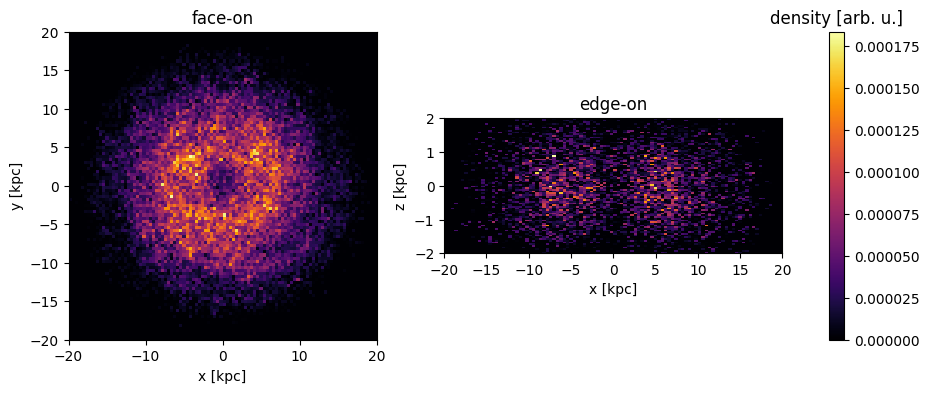

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

cmap = 'inferno'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

p1 = ax1.pcolormesh(binsX, binsY, densityDisc, cmap = cmap)
ax1.set_aspect('equal')
ax1.set_title('face-on')
ax1.set_xlim(-20, 20)
ax1.set_ylim(-20, 20)
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

p2 = ax2.pcolormesh(binsX, binsZ, densityHeight, cmap = cmap)
ax2.set_aspect(4)
ax2.set_title('edge-on')
ax2.set_xlim(-20, 20)
ax2.set_ylim(-2, 2)
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('z [kpc]')

cb = fig.colorbar(p1, ax = (ax1, ax2))
cb.ax.set_title('density [arb. u.]');

### Plotting: escape spectrum


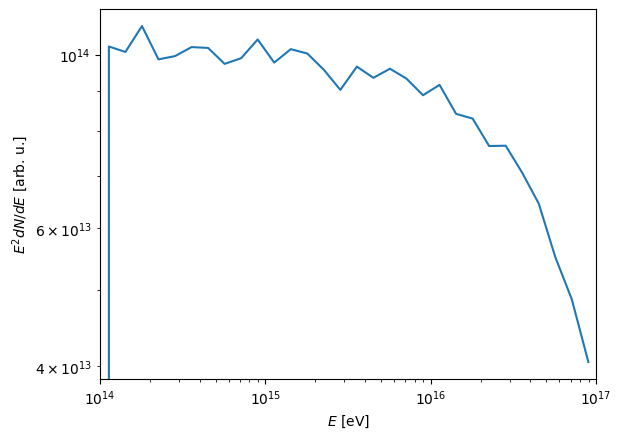

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure()
plt.plot(*specEscape, label = 'escape')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('$E$ [eV]')
plt.xlim(1e14, 1e17)
plt.show()
